# Convolution over a Region of Interest

Convolution is an important concept in image processing in which a kernel is applied over an image, typically as a window that slides along pxiels. In FFT convolution image and kernel spatial data is transformed into the frequency domain, multiplied, and transformed back into the spatial domain. This process offers a certain degree of speedup when accelerated with exterior GPU hardware for large images.

ITK FFT filters always apply operations over the largest possible region in the input image in order to accurately represent the image in the frequency domain. While sound, this approach reduces potential speedup when attempting to operate on only a small region of a much larger input image, such as in the case of generating multiscale pyramids for image registration. A workaround for this is to crop the input image to the image subregion size padded by the kernel width so that the same information is operated on by convolution in either the spatial or frequency domain.

This notebook serves to demonstrate spatial vs frequency approaches and compare outputs to validate accuracy.

Note that default notebook output uses ITK Vnl FFT backends without VkFFT speedup so that it is easier to compare FFT convolution runtime between full and cropped images. Developers are invited to install itk-vkfft and re-run for accelerated performance.

In [1]:
import time

import itk
import numpy as np
import matplotlib.pyplot as plt

itk.auto_progress(2)

# Load relevant modules in advance
itk.FFTConvolutionImageFilter


Loading ITKPyBase... done
Loading ITKCommon... done
Loading ITKStatistics... done
Loading ITKImageFilterBase... done
Loading ITKTransform... done
Loading ITKMesh... done
Loading ITKImageFunction... done
Loading ITKSpatialObjects... done
Loading ITKImageCompose... done
Loading ITKImageStatistics... done
Loading ITKPath... done
Loading ITKImageGrid... done
Loading ITKImageIntensity... done
Loading ITKThresholding... done
Loading ITKFFT... Loading ITKImageSources... done
Loading VkFFTBackend... done
done
Loading ITKConvolution... done


<itkTemplate itk::FFTConvolutionImageFilter>

In [2]:
# Define types

dimension = 2
pixel_type = itk.F
image_type = itk.Image[pixel_type, dimension]
region_type = itk.ImageRegion[dimension]


## Generate Inputs

Define a basic input image and region of interest for convolution, along with a kernel for blurring. Note that numpy and ITK use reversed conventions for indexing (KJI versus IJK).

Loading ITKBridgeNumPy... done
Loading ITKPyUtils... done


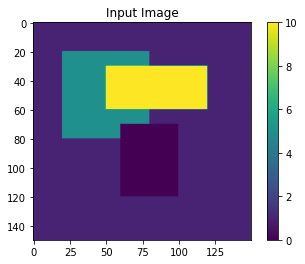

Image region of interest starts at itkIndex2 ([30, 50]) and has size itkSize2 ([80, 50])


done


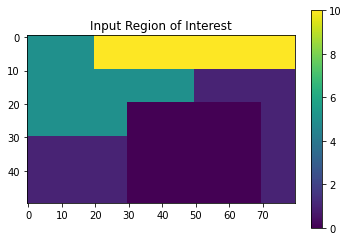

In [3]:
# Generate an input image and visualize ROI


def make_image() -> image_type:
    """Use numpy to generate an input image"""
    arr = np.ones([150, 150], dtype=np.float32)
    arr[20:80, 20:80] = 5
    arr[70:120, 60:100] = 0
    arr[30:60, 50:120] = 10
    image = itk.image_from_array(arr)
    return image


def make_roi() -> region_type:
    """Generate the region of interest with ITK"""
    region = region_type()
    region.SetSize([80, 50])
    region.SetIndex([30, 50])

    return region


largest_image = make_image()
roi = make_roi()

# The input image depicts total available spatial data
plt.title("Input Image")
plt.imshow(largest_image)
plt.colorbar()
plt.show()

# The region of interest represents the spatial region that we want after blurring.
# Here we visualize that region by cropping the input image accordingly.
# Convolution requires information extending beyond the bounds of the region, so
# we cannot crop the input to the exact region of interest when we use it in our pipeline.
print(
    f"Image region of interest starts at {roi.GetIndex()} and has size {roi.GetSize()}"
)
input_region_of_interest = itk.region_of_interest_image_filter(
    largest_image, region_of_interest=roi
)
plt.title("Input Region of Interest")
plt.imshow(input_region_of_interest)
plt.colorbar()
plt.show()


Kernel image has size itkSize2 ([15, 15])


Running itkGaussianImageSourceIF2... done


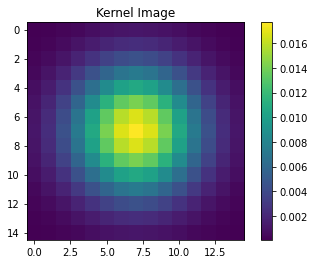

In [4]:
# Generate a kernel for convolution.
# Here we use a Gaussian kernel for blurring.
def generate_kernel() -> image_type:
    """Generate a Gaussian kernel image with ITK"""
    kernel_source = itk.GaussianImageSource[image_type].New()
    kernel_source.SetSize(15)
    kernel_source.SetMean(7)
    kernel_source.SetSigma(3.0)
    kernel_source.SetScale(1.0)
    kernel_source.SetNormalized(True)
    kernel_source.Update()
    return kernel_source.GetOutput()


# Note that the size of the spatial kernel image is significantly less than that of the input image.
# In spatial convolution this kernel will "slide" as a window along the input image.
# In convolution in the frequency domain the kernel frequency representation will be transformed to
# the same size as the input image's frequency representation.
kernel_image = generate_kernel()
print(f"Kernel image has size {itk.size(kernel_image)}")
plt.title("Kernel Image")
plt.imshow(kernel_image)
plt.colorbar()
plt.show()


## Demonstrate Spatial Convolution

Here we show that convolution results within the output ROI do not differ significantly when the image is cropped to a subregion that is the ROI padded to the kernel width. This padding effectively provides all relevant input signal to the convolution.

Running <function convolution_image_filter at 0x000002058376CAF0>
Cropping to region of size [80, 50]
Pipeline ran in 0.009s


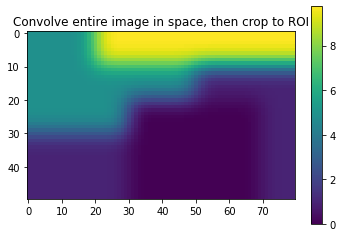

In [5]:
def convolve_then_crop(
    image, kernel, region, filter_fn=itk.convolution_image_filter
) -> image_type:
    """Brute-force: Run spatial convolution on the entire image, then crop the output to the region of interest"""
    starttime = time.time()
    print(f"Running {filter_fn}")
    blurred = filter_fn(image, kernel_image=kernel)
    print(f"Cropping to region of size {list(region.GetSize())}")
    cropped = itk.region_of_interest_image_filter(blurred, region_of_interest=region)
    print(f"Pipeline ran in {time.time() - starttime:0.3f}s")
    return cropped


largest_result = convolve_then_crop(largest_image, kernel_image, roi)
plt.title("Convolve entire image in space, then crop to ROI")
plt.imshow(largest_result)
plt.colorbar()
plt.show()


Cropping to region of size [94, 64]
Running <function convolution_image_filter at 0x000002058376CAF0>
Cropping to region of size [80, 50]
Pipeline ran in 0.005s


done


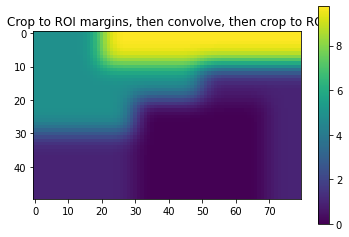

In [6]:
def crop_then_convolve_then_crop(
    image, kernel, region, filter_fn=itk.convolution_image_filter
) -> image_type:
    """Crop input as close as possible to the output ROI
    without removing relevant boundaries for convolution kernel width"""
    starttime = time.time()
    # Pad region by kernel radius on all sides
    kernel_radius = [int((itk.size(kernel)[dim] - 1) / 2) for dim in range(dimension)]
    roi_first = region_type()
    roi_first.SetIndex(
        [int(region.GetIndex()[dim] - kernel_radius[dim]) for dim in range(dimension)]
    )
    roi_first.SetSize(
        [
            region.GetSize()[dim] + (itk.size(kernel)[dim] - 1)
            for dim in range(dimension)
        ]
    )

    roi_second = region_type()
    roi_second.SetSize(region.GetSize())
    roi_second.SetIndex([kernel_radius[dim] for dim in range(dimension)])

    print(f"Cropping to region of size {list(roi_first.GetSize())}")
    cropped_first = itk.region_of_interest_image_filter(
        image, region_of_interest=roi_first
    )
    print(f"Running {filter_fn}")
    blurred = filter_fn(cropped_first, kernel_image=kernel)
    print(f"Cropping to region of size {list(roi_second.GetSize())}")
    cropped_second = itk.region_of_interest_image_filter(
        blurred, region_of_interest=roi_second
    )

    print(f"Pipeline ran in {time.time() - starttime:0.3f}s")

    return cropped_second


cropped_result = crop_then_convolve_then_crop(largest_image, kernel_image, roi)
plt.title("Crop to ROI margins, then convolve, then crop to ROI")
plt.imshow(cropped_result)
plt.colorbar()
plt.show()


Max difference: 0.0


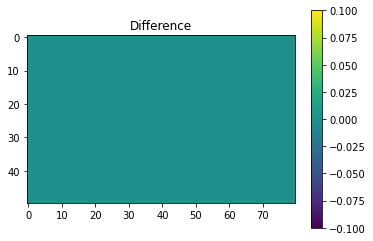

In [7]:
# Compare results to show that difference in output is negligible
diff = itk.array_from_image(cropped_result) - itk.array_from_image(largest_result)
print(f"Max difference: {np.max(diff)}")
plt.title("Difference")
plt.imshow(diff)
plt.colorbar()
plt.show()


## Demonstrate FFT Convolution

Here we take a similar approach to show that convolution in the frequency domain produces the same results in the region of interest if run on the entire image and cropped or run on a specific subregion and cropped.

Running <function fft_convolution_image_filter at 0x0000020583774DC0>
Cropping to region of size [80, 50]
Pipeline ran in 5.656s


done


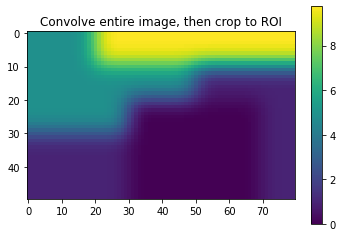

In [8]:
# Blur entire image with FFT convolution, then crop to ROI
largest_result = convolve_then_crop(
    largest_image, kernel_image, roi, filter_fn=itk.fft_convolution_image_filter
)
plt.title("Convolve entire image, then crop to ROI")
plt.imshow(largest_result)
plt.colorbar()
plt.show()


Cropping to region of size [94, 64]
Running <function fft_convolution_image_filter at 0x0000020583774DC0>
Cropping to region of size [80, 50]
Pipeline ran in 3.939s


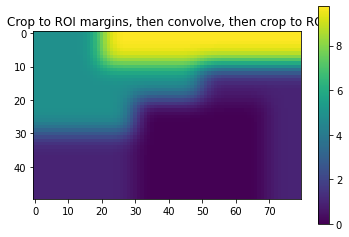

In [9]:
# Crop to a specific subregion padded for the kernel, then run FFT convolution, then crop remaining to ROI
cropped_result = crop_then_convolve_then_crop(
    largest_image, kernel_image, roi, filter_fn=itk.fft_convolution_image_filter
)
plt.title("Crop to ROI margins, then convolve, then crop to ROI")
plt.imshow(cropped_result)
plt.colorbar()
plt.show()


Max difference: 0.000


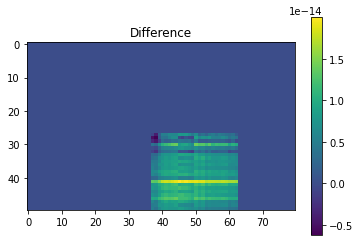

In [10]:
# Compare results to show that difference in output is negligible
diff = itk.array_from_image(cropped_result) - itk.array_from_image(largest_result)
print(f"Max difference: {np.max(diff):.3f}")
plt.title("Difference")
plt.imshow(diff)
plt.colorbar()
plt.show()


## Compare Spatial and FFT Convolution Accuracy

Here we demonstrate equivalence between the results of spatial and FFT convolution. Colorbars show that image differences are negligible in pixel magnitude.

Running <function convolution_image_filter at 0x000002058376CAF0>
Cropping to region of size [80, 50]
Pipeline ran in 0.009s
Running <function fft_convolution_image_filter at 0x0000020583774DC0>
Cropping to region of size [80, 50]
Pipeline ran in 4.535s
Cropping to region of size [94, 64]
Running <function convolution_image_filter at 0x000002058376CAF0>
Cropping to region of size [80, 50]
Pipeline ran in 0.006s
Cropping to region of size [94, 64]
Running <function fft_convolution_image_filter at 0x0000020583774DC0>
Cropping to region of size [80, 50]
Pipeline ran in 4.102s


done
done
done
done


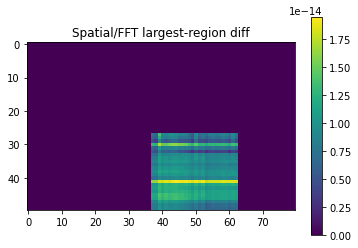

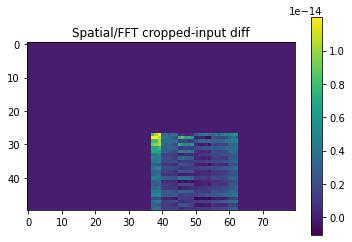

In [11]:
spatial_largest = convolve_then_crop(
    largest_image, kernel_image, roi, filter_fn=itk.convolution_image_filter
)
fft_largest = convolve_then_crop(
    largest_image, kernel_image, roi, filter_fn=itk.fft_convolution_image_filter
)
spatial_cropped = crop_then_convolve_then_crop(
    largest_image, kernel_image, roi, filter_fn=itk.convolution_image_filter
)
fft_cropped = crop_then_convolve_then_crop(
    largest_image, kernel_image, roi, filter_fn=itk.fft_convolution_image_filter
)

plt.title("Spatial/FFT largest-region diff")
plt.imshow(itk.array_from_image(spatial_largest) - itk.array_from_image(fft_largest))
plt.colorbar()
plt.show()

plt.title("Spatial/FFT cropped-input diff")
plt.imshow(itk.array_from_image(spatial_cropped) - itk.array_from_image(fft_cropped))
plt.colorbar()
plt.show()
